# **Boosted Decision Trees**

Random Forest and Boosted Decision Trees both are based on Decision Trees to make predictions. However, Random Forest uses **Bagging**, which relies on training learners in parallel on different samples of the data and then combining by voting (discrete output) or by averaging (continuous output). It is really easy to implement and to parallelize (and therefore one of the most popular classifier for dense data). Whereas Boosted Decision Trees uses **Boosting**, which relies on training learner again, but after filtering/weighting samples based on output of previous train/test runs. In contrast to Random Forest, here the trees are trained independently as they are trained sequentially by boosting (meaning that each tree is trained to predict error residuals of previous trees). This technic allows to reduce the bias.

After many researches on the internet [citation needed](citationlink), we found that actually **Random Forest is not really suited for classification problems with a skewed class distribution**. However, according to the literature [citation needed](citationlink), Boosted Decision Trees seems less sensitive to such imbalanced dataset. This is why we will implement it and test this hypothesis.

### 1) Kind of Boosted Decision Trees?

`sklearn` offers such a Boosting Decision Trees classifier: `AdaBoostClassifer`. 

Here is a bit of knowledge about AdaBoost : "The core principle of AdaBoost is to **fit a sequence of weak learners** (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a **weighted majority vote** (or sum) to produce the final prediction. The data modifications at each so-called **boosting iteration consist of applying weights $w_i$ to each of the training samples**. Initially, those weights are all set to $w_i = 1/N$ so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, **those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly**. As iterations proceed, **examples that are difficult to predict receive ever-increasing influence**. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence"

With this, we understand clearly here why this kind of Boosted Decision Trees has better chance to handle imbalanced dataset. Civil War Onsets being really rare and hard to predict events, it will receive an ever-increasing influence through the weights until it balances out the fact that they are rare in the dataset. This why, we can hope that the model will be better suited (than RF) to predict these kind of events as it will be forced to concentrate on these hard to detected (because rare) events missed by the previous trees.

### 2) Libraries

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import roc_curve, auc
from helpers import load_data

### 3) Pre-processing

In [3]:
##load the data 

DATA_PATH = '../data/'
seed = 7

data = load_data(DATA_PATH)
features, target = data['muchlinski']

display(features)
display(target)

,ager,agexp,anoc,army85,autch98,auto4,autonomy,avgnabo,centpol3,coldwar,...,seceduc,second,semipol3,sip2,sxpnew,sxpsq,tnatwar,trade,warhist,xconst
X,,,,,,,,,,,,,,,,,,,,,
1,34.461765,8.510845,0,129472.9042,0,3.925812,0.005151,0.432955,1,1,...,43.770298,0.253000,0.058441,0.46176,0.158275,0.052989,0.443259,72.881375,0,3.995912
2,34.346348,8.478997,0,129413.0225,0,10.000000,0.000000,0.045052,1,1,...,43.588363,0.253000,0.000000,0.00000,0.158321,0.052663,1.000000,72.900089,0,1.000000
3,77.000000,8.481015,0,130431.0145,0,10.000000,0.000000,0.030034,1,1,...,43.538181,0.253000,0.000000,0.00000,0.158425,0.052891,2.000000,72.962880,0,1.000000
4,78.000000,8.451628,0,126781.6866,0,10.000000,0.000000,0.022526,1,1,...,43.490005,0.253000,0.000000,0.00000,0.159006,0.052902,2.000000,73.102449,0,1.000000
5,79.000000,8.500172,0,130979.2470,0,10.000000,0.000000,0.022526,1,1,...,43.602238,0.253000,0.000000,0.00000,0.158074,0.052706,2.000000,72.850389,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9628,31.000000,6.760000,0,46000.0000,0,6.000000,0.000000,0.552250,1,0,...,47.299999,0.200000,0.058530,0.35749,0.175017,0.030631,0.000000,78.975510,0,3.000000
9629,32.000000,7.620000,0,46000.0000,0,6.000000,0.000000,0.552250,1,0,...,47.299999,0.200000,0.058706,0.35749,0.194624,0.037878,0.000000,72.737373,0,3.000000
9630,33.000000,10.590000,0,46000.0000,0,6.000000,0.000000,0.552250,1,0,...,47.299999,0.200000,0.058580,0.35749,0.158606,0.052775,0.000000,79.235222,0,3.000000


X
1       0
2       0
3       0
4       0
5       0
       ..
9628    0
9629    0
9630    0
9631    0
9632    0
Name: warstds, Length: 7140, dtype: int64

In [4]:
###standardization

means = features.mean()
stds = features.std()

for c in features.columns:
    features[c] = (features[c] - means[c])/stds[c]
    
display(features)

,ager,agexp,anoc,army85,autch98,auto4,autonomy,avgnabo,centpol3,coldwar,...,seceduc,second,semipol3,sip2,sxpnew,sxpsq,tnatwar,trade,warhist,xconst
X,,,,,,,,,,,,,,,,,,,,,
1,0.011565,-0.075864,-0.503682,-0.097323,0.016433,-0.005731,-0.018215,-0.053497,0.411715,0.556820,...,0.076855,0.919162,-0.007550,0.026881,0.094095,0.052437,-0.139284,0.107157,-0.454154,0.033310
2,0.008046,-0.079254,-0.503682,-0.097473,0.016433,1.775804,-0.082597,-1.315951,0.411715,0.556820,...,0.069821,0.919162,-0.287012,-1.219573,0.094547,0.049137,0.509491,0.107596,-0.454154,-1.298861
3,1.308743,-0.079039,-0.503682,-0.094927,0.016433,1.775804,-0.082597,-1.364826,0.411715,0.556820,...,0.067881,0.919162,-0.287012,-1.219573,0.095567,0.051447,1.674799,0.109070,-0.454154,-1.298861
4,1.339237,-0.082167,-0.503682,-0.104053,0.016433,1.775804,-0.082597,-1.389263,0.411715,0.556820,...,0.066018,0.919162,-0.287012,-1.219573,0.101303,0.051559,1.674799,0.112345,-0.454154,-1.298861
5,1.369731,-0.077000,-0.503682,-0.093556,0.016433,1.775804,-0.082597,-1.389263,0.411715,0.556820,...,0.070357,0.919162,-0.287012,-1.219573,0.092107,0.049569,1.674799,0.106430,-0.454154,-1.298861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9628,-0.093999,-0.262238,-0.503682,-0.306074,0.016433,0.602620,-0.082597,0.334757,0.411715,-1.795662,...,0.213322,0.415169,-0.007124,-0.254582,0.259141,-0.174152,-0.655817,0.250157,-0.454154,-0.409535
9629,-0.063505,-0.170693,-0.503682,-0.306074,0.016433,0.602620,-0.082597,0.334757,0.411715,-1.795662,...,0.213322,0.415169,-0.006284,-0.254582,0.452436,-0.100702,-0.655817,0.103778,-0.454154,-0.409535
9630,-0.033010,0.145460,-0.503682,-0.306074,0.016433,0.602620,-0.082597,0.334757,0.411715,-1.795662,...,0.213322,0.415169,-0.006889,-0.254582,0.097356,0.050272,-0.655817,0.256251,-0.454154,-0.409535


### 4) Tuning hyperparameters: Cross-validation

AdaBoostmodel depends on an hyperparameter `nt`(number of estimators, i.e. decision trees). We will now tune it using Cross-validation.

In [7]:
def plot_precision_recall_nt(number_trees):
    precision_scores = []
    recalls_scores = []
    #accuracy_scores = []

    for nt in number_trees:
        print(nt)
        clf = AdaBoostClassifier(n_estimators=nt, random_state=0)
        precision = cross_val_score(clf, features, target, cv=10, scoring="precision")
        precision_scores.append(precision.mean())
        recall = cross_val_score(clf, features, target, cv=10, scoring="recall")
        recalls_scores.append(recall.mean())
        #accuracy = cross_val_score(clf, features, target, cv=10, scoring="accuracy")
        #accuracy_scores.append(accuracy.mean())
    
    return precision_scores, recalls_scores

In [6]:
precision_scores, recalls_scores = plot_precision_recall_nt([50, 100, 250, 500, 750, 1000])

50
100
250
500
750
1000


Note here that it would be tempting to compute accuracy, but that this measures is meaningless in such a imbalanced dataset.

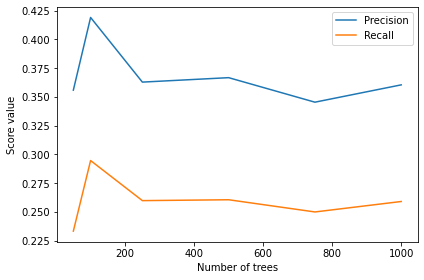

In [7]:
fig, ax = plt.subplots(1,figsize=(6,4))

ax.plot(number_trees, precision_scores, label="Precision")
ax.plot(number_trees, recalls_scores, label="Recall")

ax.set_ylabel("Score value")
ax.set_xlabel("Number of trees")
ax.legend()

fig.tight_layout()

Precision as well as Recall seems higher around 100 estimators. Let's plot this again for nt in that range.

In [10]:
precision_scores, recalls_scores = plot_precision_recall_nt([70,80,90,100,110,120,130,140,150,160])

70
80
90
100
110
120
130
140
150
160


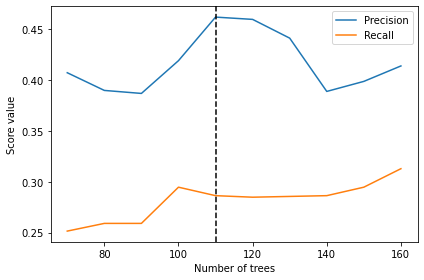

In [18]:
fig, ax = plt.subplots(1,figsize=(6,4))
number_trees = [70,80,90,100,110,120,130,140,150,160]
ax.plot(number_trees, precision_scores, label="Precision")
ax.plot(number_trees, recalls_scores, label="Recall")
ax.axvline(x=110, c = 'black', linestyle = '--')

ax.set_ylabel("Score value")
ax.set_xlabel("Number of trees")
ax.legend()

fig.tight_layout()

**nt = 110** seems to be a good number of trees (by default it's 50). Note that we chose 110 and not 100 because of the massive increase of Precision (which compensate for the negligeable decrease in recall). 

AdaBoostClassifier has another hyperparameter : `base_estimator` which is DecisionTreeClassifier(max_depth=1) by default. We can tune the max_depth via cross-validation.

In [19]:
max_depth = [i for i in range(1,11)]
precision_scores = []
recalls_scores = []
#accuracy_scores = []

nt = 110 #tuned

for depth in max_depth:
    print(depth)
    clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = depth), n_estimators=nt, random_state=0)
    precision = cross_val_score(clf, features, target, cv=10, scoring="precision")
    precision_scores.append(precision.mean())
    recall = cross_val_score(clf, features, target, cv=10, scoring="recall")
    recalls_scores.append(recall.mean())
    #accuracy = cross_val_score(clf, features, target, cv=10, scoring="accuracy")
    #accuracy_scores.append(accuracy.mean())

1
2
3
4
5
6
7


/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


8


/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9


/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10


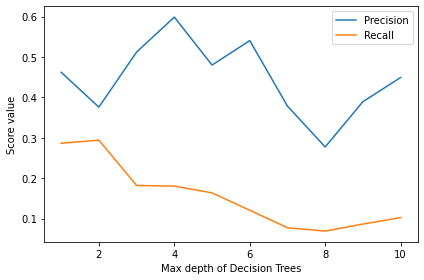

In [20]:
fig, ax = plt.subplots(1,figsize=(6,4))

ax.plot(max_depth, precision_scores, label="Precision")
ax.plot(max_depth, recalls_scores, label="Recall")

ax.set_ylabel("Score value")
ax.set_xlabel("Max depth of Decision Trees")
ax.legend()

fig.tight_layout()

Here we see that the bigger the max_depth, the bigger the Precision but the lower the Recall. We have to think about what's best for our application. Should we care more about Precision or about Recall? And to what extend? After testing with different number of trees, we obtain better ROC curves with 4 and thus will keep this value.

AdaBoostClassifier has another hyperparameter : `learning_rate`. We can tune the max_depth via cross-validation.

In [49]:
learning_rates = [0.1,0.5,1,1.5,2,5]
precision_scores = []
recalls_scores = []
#accuracy_scores = []

nt = 110 #tuned
depth = 4 #tuned

for learning_rate in learning_rates:
    print(learning_rate)
    clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = depth), n_estimators=nt, random_state=0, learning_rate=learning_rate)
    precision = cross_val_score(clf, features, target, cv=10, scoring="precision")
    precision_scores.append(precision.mean())
    recall = cross_val_score(clf, features, target, cv=10, scoring="recall")
    recalls_scores.append(recall.mean())
    #accuracy = cross_val_score(clf, features, target, cv=10, scoring="accuracy")
    #accuracy_scores.append(accuracy.mean())

0.1
0.5
1
1.5
2


/home/loic/anaconda3/envs/ada/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5


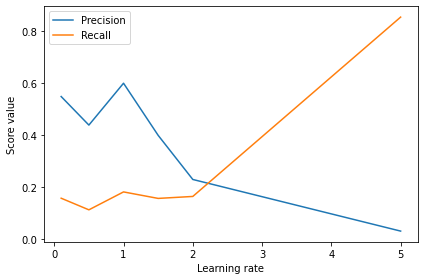

In [53]:
fig, ax = plt.subplots(1,figsize=(6,4))

ax.plot(learning_rates, precision_scores, label="Precision")
ax.plot(learning_rates, recalls_scores, label="Recall")


ax.set_ylabel("Score value")
ax.set_xlabel("Learning rate")
ax.legend()

fig.tight_layout()

Here we see that the best performance is obtained for the learning rate = 1 (by default). Note that there exists obviously a trade-off between learning_rate and n_estimators.

### 5) Comparing the models: ROC curves

Now that we have tuned our AdaBoostClassifier, we will compare its performances to the other classifiers using ROC curves

In [9]:
nt = 110 #tuned
AdaBoostmodel = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=4), n_estimators=nt, random_state = 1)

We will first make target predictions using cross-validation.

In [10]:
target_prediction_AdaBoostmodel = cross_val_predict(AdaBoostmodel, features, target, cv = 10, method="predict_proba")

Then use the result to compute its ROC curve:

In [13]:
FPR_AdaBoostmodel, TPR_AdaBoostmodel, thresholds = roc_curve(target, target_prediction_AdaBoostmodel[:, 1])

We will also compute its AUC score:

In [15]:
AUC_AdaBoostmodel = auc(FPR_AdaBoostmodel, TPR_AdaBoostmodel)

And now plot it:

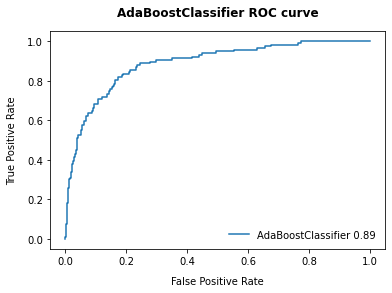

In [17]:
plt.plot(FPR_AdaBoostmodel, TPR_AdaBoostmodel, label = "AdaBoostClassifier {:.2f}".format(AUC_AdaBoostmodel))
plt.legend(frameon = False)
plt.xlabel("False Positive Rate", labelpad = 10)
plt.ylabel("True Positive Rate", labelpad = 10)
plt.title("AdaBoostClassifier ROC curve", pad = 15, fontweight = 'bold')
plt.savefig("../pictures/AdaBoostClassifier_ROC_curve.png")

Here is the Random Forest's ROC curve:

<img src="../pictures/Random_forest_ROC_curve.png" width="425"/>

As expected, our AdaBoostClassifier scores better than any of the Logistic Regression methods, but a bit worse than Random Forest.

**To do : F1 score + features importance**